In [1]:
from SFC_Jax.Fmodel import SFcalculator

In [2]:
import reciprocalspaceship as rs
import numpy as np

In [3]:
sfcalculator = SFcalculator("../data/4xof.pdb", mtzfile_dir="../data/4xof.mtz", set_experiment=True)

In [6]:
sfcalculator.inspect_data(dmin_mask=6.0)

Solvent Percentage: 0.113
Grid size: [80, 120, 144]
P1 HKL length:  579


In [7]:
Fprotein = sfcalculator.Calc_Fprotein(Print=True)

In [8]:
Fsolvent = sfcalculator.Calc_Fsolvent(Print=True, dmin_nonzero=3.0)

In [9]:
Fprotein_arr = np.array(Fprotein)
Fsolvent_arr = np.array(Fsolvent)

### Compare with Phenix

In [10]:
Fcalc = rs.read_mtz('../data/4xof_vanilla.mtz')

In [11]:
Fmodel=rs.read_mtz('../data/4xof_ksol1.mtz')

In [12]:
(Fmodel.get_hkls() == Fcalc.get_hkls()).all()

True

In [13]:
calc_mag = Fcalc['FMODEL'].to_numpy()
calc_ph = np.deg2rad(Fcalc['PHIFMODEL'].to_numpy())
Fcalc_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(calc_mag,calc_ph)])

In [14]:
model_mag = Fmodel['FMODEL'].to_numpy()
model_ph = np.deg2rad(Fmodel['PHIFMODEL'].to_numpy())
Fmodel_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(model_mag,model_ph)])

In [15]:
Fmask_complex = Fmodel_complex - Fcalc_complex

In [16]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr,spearmanr

def linear_corr(a,b):
    reg = LinearRegression().fit(a.reshape(-1,1),b.reshape(-1,1))
    print("Linear Fit Coeff:", reg.coef_)
    print("R square:", reg.score(a.reshape(-1,1),b.reshape(-1,1)))
    print("Pearsonr:", pearsonr(a,b))
    print("Spearmanr:", spearmanr(a,b))
    
def comp_plot(mag_a, mag_b, ph_a, ph_b, name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,2,figsize=[10,4], dpi=dpi)
    ax[0].plot(mag_a, mag_b, '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Magnitude")

    ax[1].plot(ph_a, ph_b, '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Phase")
    plt.show()
    
def comp_plot_complex(a,b,name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,3,figsize=[15,4], dpi=dpi)
    ax[0].plot(np.real(a), np.real(b), '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Real Part")

    ax[1].plot(np.imag(a), np.imag(b), '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Imaginary Part")

    ax[2].plot(np.abs(a), np.abs(b), '.', alpha=0.4)
    ax[2].set_xlabel(name_a)
    ax[2].set_ylabel(name_b)
    ax[2].set_title("Magnitude")
    plt.show()

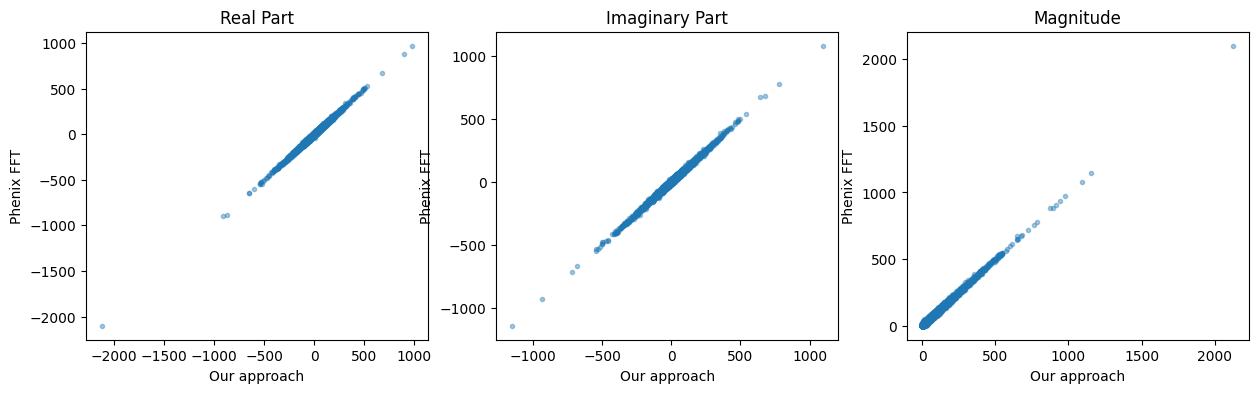

In [17]:
# Protein Part
comp_plot_complex(Fprotein_arr, Fcalc_complex, "Our approach", "Phenix FFT", dpi=100)

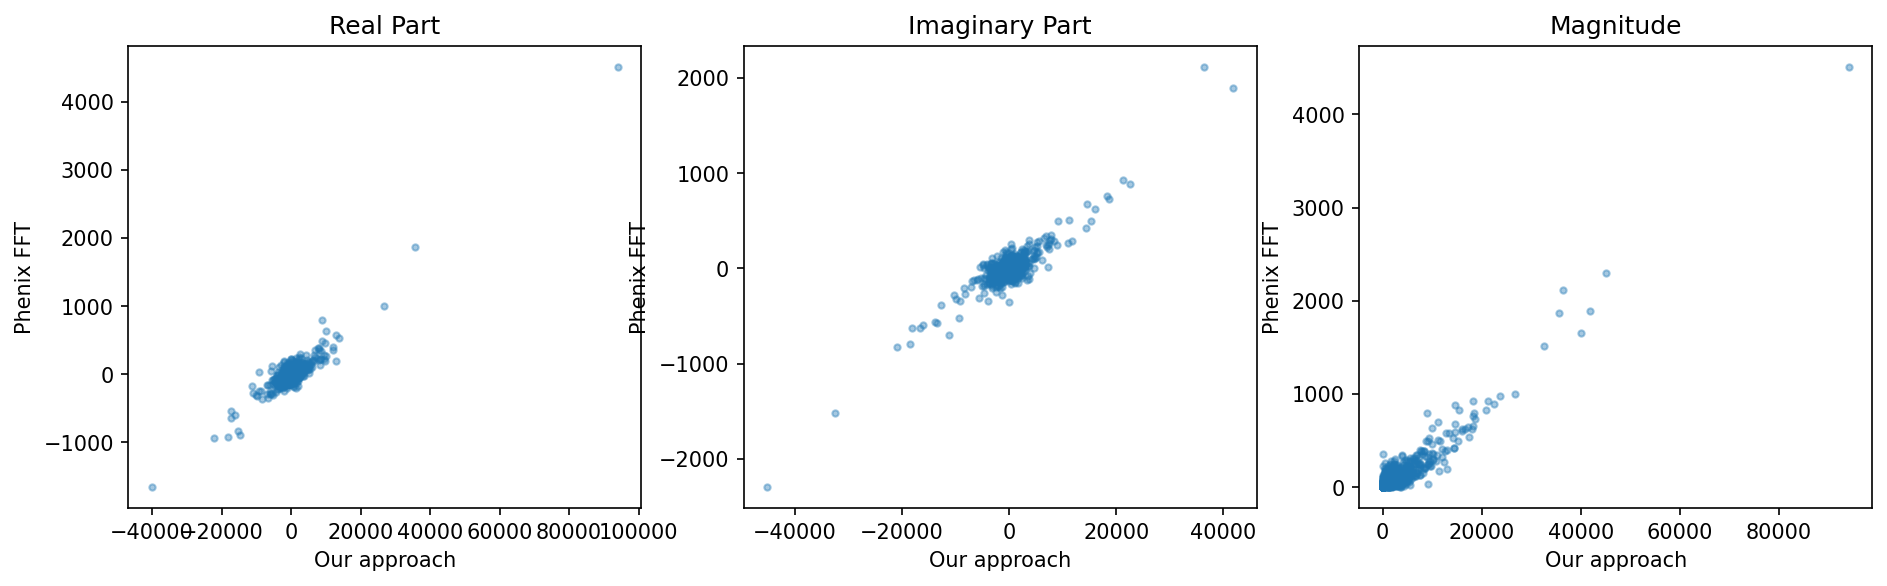

In [18]:
comp_plot_complex(Fsolvent_arr, Fmask_complex, "Our approach", "Phenix FFT", dpi=150)

### Gradient Descent for the scales

In [19]:
import jax
import optax
import flax
import jax.numpy as jnp
import time

In [20]:
from SFC_Jax.utils import r_factor

In [21]:
initial_params = {
    'kall': jnp.array([1.0]),
    'kaniso': jax.random.normal(key=jax.random.PRNGKey(42), shape=[6])*0.01+0.01,
    'ksol': jnp.array([0.03]),
    'bsol': jnp.array([15.0]),    
}

In [22]:
def loss(params: optax.Params) -> jnp.ndarray:
    Fmodel = sfcalculator.Calc_Ftotal(kall=params['kall'], 
                                      kaniso=params['kaniso'], 
                                      ksol=params['ksol'], 
                                      bsol=params['bsol'])
    Fmodel_mag = jnp.abs(Fmodel)
    error = jnp.sum((sfcalculator.Fo - Fmodel_mag)**2)
    r_work, r_free = r_factor(sfcalculator.Fo, Fmodel_mag, sfcalculator.rwork_id, sfcalculator.rfree_id)
    return error, (r_work, r_free)

In [23]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation, n_steps: int) -> optax.Params:
    opt_state = optimizer.init(params) 
    
    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss, has_aux=True)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(n_steps):
        start_time = time.time()
        params, opt_state, (loss_value, (r_work, r_free)) = step(params, opt_state)
        time_this_round = round(time.time() - start_time, 3)
        print(f'step {i}, loss: {loss_value}, R_work: {r_work}, R_free: {r_free}, time: {time_this_round}')
    return params

In [24]:
optimizer = optax.adam(learning_rate=1e-2)
params = fit(initial_params, optimizer, 2000)

step 0, loss: 8109787.0, R_work: 0.21615439653396606, R_free: 0.23999172449111938, time: 0.877
step 1, loss: 5287805.0, R_work: 0.18734516203403473, R_free: 0.20583246648311615, time: 0.0
step 2, loss: 5927056.0, R_work: 0.17658750712871552, R_free: 0.21054893732070923, time: 0.0
step 3, loss: 6325308.0, R_work: 0.1799534410238266, R_free: 0.21562443673610687, time: 0.0
step 4, loss: 5521498.0, R_work: 0.18341593444347382, R_free: 0.21362237632274628, time: 0.0
step 5, loss: 4938870.0, R_work: 0.1835298091173172, R_free: 0.20765602588653564, time: 0.0
step 6, loss: 5055672.5, R_work: 0.18267133831977844, R_free: 0.20491422712802887, time: 0.0
step 7, loss: 5393568.0, R_work: 0.18218189477920532, R_free: 0.20827381312847137, time: 0.0
step 8, loss: 5521361.0, R_work: 0.18260487914085388, R_free: 0.2068495899438858, time: 0.0
step 9, loss: 5497409.0, R_work: 0.1830790638923645, R_free: 0.20739948749542236, time: 0.0
step 10, loss: 5280594.0, R_work: 0.18251611292362213, R_free: 0.2055833

In [25]:
params

{'bsol': DeviceArray([32.431297], dtype=float32),
 'kall': DeviceArray([0.9396501], dtype=float32),
 'kaniso': DeviceArray([-0.01623704, -0.00712131, -0.01210425, -0.25712097,
              -0.05600027, -0.14341982], dtype=float32),
 'ksol': DeviceArray([0.01823636], dtype=float32)}